In [1]:
import torch
from matplotlib import pyplot as plt
from the_well.data import WellDataset
from torch.utils.data import DataLoader
import numpy as np

from dataclasses import dataclass
from datasets import load_dataset

from torchvision import transforms
import torch

from accelerate import Accelerator
from huggingface_hub import create_repo, upload_folder
from tqdm.auto import tqdm
from pathlib import Path
import os
import torch.nn.functional as F
from matplotlib import pyplot as plt
from accelerate import notebook_launcher
from diffusers.optimization import get_cosine_schedule_with_warmup
from diffusers import UNet2DModel
from diffusers import DDPMScheduler
from diffusers import DDPMPipeline
from diffusers.utils import make_image_grid
import os
from PIL import Image
import glob
import numpy as np
from torchvision.transforms import InterpolationMode

In [2]:
@dataclass
class TrainingConfig:
    image_size = 128  
    train_batch_size = 16
    eval_batch_size = 16  
    num_epochs = 1000
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 10
    save_model_epochs = 10
    mixed_precision = "fp16" 
    output_dir = "ddpm-active-matter-128"  

    push_to_hub = False 
    overwrite_output_dir = True  
    seed = 42
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



config = TrainingConfig()


In [3]:
dataset = WellDataset(
    well_base_path="./../the_well/datasets/",
    well_dataset_name="active_matter",
    well_split_name="train"
)

train_dataloader = DataLoader(dataset, batch_size=config.train_batch_size, shuffle=True)
avg_pool = torch.nn.AvgPool2d(kernel_size=2, stride=2)


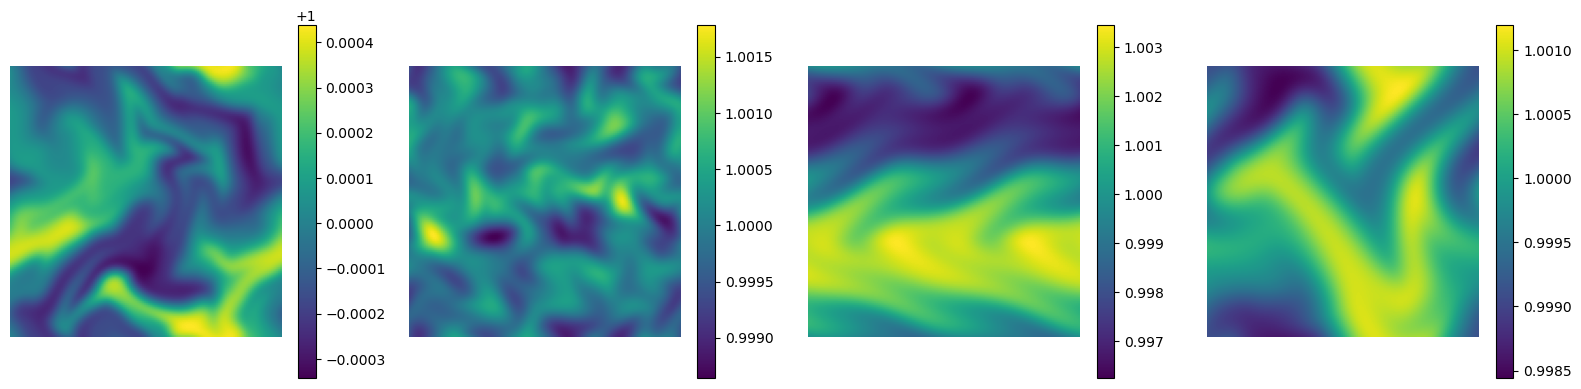

In [4]:

random_samples = [dataset[i] for i in torch.randint(len(dataset), (4,))]

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, sample in enumerate(random_samples):
    image = sample['input_fields'].squeeze(0).permute(2, 0, 1)[0, :, :].unsqueeze(0)
    
    image = avg_pool(image)
    
    im = axs[i].imshow(image.squeeze(), cmap='viridis')
    axs[i].set_axis_off()
    fig.colorbar(im, ax=axs[i])


plt.tight_layout()
plt.show()

In [5]:
from diffusers import UNet2DModel
from diffusers import UNet2DConditionModel

model = UNet2DModel(
    sample_size=config.image_size, 
    in_channels=1, 
    out_channels=1,  
    layers_per_block=2,  
    block_out_channels=(128, 128, 256, 256, 512, 512),  
    down_block_types=(
        "DownBlock2D",  
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",  
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",  
        "AttnUpBlock2D",  
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)

noise_scheduler = DDPMScheduler(num_train_timesteps=1000, 
                                clip_sample=False)
optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_dataloader) * config.num_epochs),
)



In [6]:
loss_history = []
epoch_start = 0


def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):

    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        log_with="tensorboard",
        project_dir=os.path.join(config.output_dir, "logs"),
    )
    if accelerator.is_main_process:
        os.makedirs(config.output_dir, exist_ok=True)
        accelerator.init_trackers("train_example")

    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )


    global_step = 0
    #loss_history = []  

    for epoch in range(epoch_start, epoch_start + config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process, desc=f"Epoch {epoch}")
        epoch_loss = 0.0  
        num_batches = 0   
        
        for step, batch in enumerate(train_dataloader):
            images = avg_pool(batch['input_fields'].squeeze(1).permute(0, 3, 1, 2)[:, 0, :, :].unsqueeze(1))

            noise = torch.randn(images.shape, device=images.device)
            timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (images.shape[0],), device=images.device, dtype=torch.int64)
            noisy_images = noise_scheduler.add_noise(images, noise, timesteps)
            
            with accelerator.accumulate(model):
                noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
                
                loss = F.mse_loss(noise_pred, noise)
                
                accelerator.backward(loss)
                if accelerator.sync_gradients:
                    accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1

            epoch_loss += loss.item()
            num_batches += 1

            # Save loss value every 10 batches
            if step % 10 == 0:
                loss_history.append(loss.item())

        if accelerator.is_main_process:
            pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)

            if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
                evaluate(config, epoch, pipeline)
                
                # Plot and save loss graph
                plt.figure(figsize=(10, 5))
                plt.plot(loss_history)
                plt.yscale('log')  
                plt.title('Training Loss')
                plt.xlabel('Steps (x10)')
                plt.ylabel('Loss (log scale)')
                plt.savefig(os.path.join(config.output_dir, "samples", "loss_graph.png"))
                plt.close()
                save_dir = os.path.join(config.output_dir, "samples", "checkpoint-{epoch}")
                accelerator.save_state(save_dir)

            if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                pipeline.save_pretrained(config.output_dir)

    accelerator.end_training()

def evaluate(config, epoch, pipeline):
    pipeline.unet.eval()
    
    images = pipeline(
        batch_size=config.eval_batch_size,
        generator=torch.Generator(device='cpu').manual_seed(config.seed),
        output_type="tensor"
    ).images
    
    # Create a matplotlib figure with 4x4 grid
    import matplotlib.pyplot as plt
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    
    for i, img in enumerate(images):
        row = i // 4
        col = i % 4
        
        if isinstance(img, torch.Tensor):
            img = img.cpu().squeeze().numpy()  
        
        axes[row, col].imshow(img) 
        axes[row, col].axis('off')
        plt.colorbar(axes[row, col].images[0], ax=axes[row, col]) 
    
    plt.tight_layout()
    
    test_dir = os.path.join(config.output_dir, "samples")
    os.makedirs(test_dir, exist_ok=True)
    
    plt.savefig(f"{test_dir}/{(epoch):04d}.png", dpi=150, bbox_inches='tight')
    plt.close(fig)  
    return images


In [ ]:
device = config.device
args = (config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)
loss_history = notebook_launcher(train_loop, args, num_processes=1)


# VALIDATION

In [ ]:
from diffusers import DiffusionPipeline
import json
import torch
import time
import importlib
import os
import custom_scheduler_active_matter
importlib.reload(custom_scheduler_active_matter)
import sys 
sys.path.append(os.path.abspath('..'))

import custom_scheduler_base
importlib.reload(custom_scheduler_base)

pipe = DiffusionPipeline.from_pretrained('./ddpm-active-matter-128', use_safetensors=True).to("cuda")

# Load loss history from file 
with open(os.path.join(config.output_dir, 'loss_history.json'), 'r') as f:
    loss_history = json.load(f)


def sample_arbitrary(config, pipeline, batch = 16, num_inference_steps=1000):
    images = torch.randn((batch, 1, 128, 128), device=config.device)
    
    pipeline.scheduler.set_timesteps(num_inference_steps)
    progress_bar = tqdm(total=num_inference_steps, desc=f"yoyoyo")

    pipeline.unet.eval()
    pipeline.unet.to(config.device)

    for t in pipeline.scheduler.timesteps:
        timestep = torch.full((1,), t, device=config.device, dtype=torch.long)
        with torch.no_grad():
            noise_pred = pipeline.unet(images, timestep).sample
        
        images = pipeline.scheduler.step(noise_pred, t, images).prev_sample
        progress_bar.update(1)
    pipeline.unet.train()
    return images.detach().cpu()

In [ ]:
def generate_samples(config, pipe, num_samples=1000, batch_size=32):

    num_batches = (num_samples + batch_size - 1) // batch_size
    
    conditional_samples = []
    unconditional_samples = []
    
    pipe.scheduler = custom_scheduler_active_matter.CustomScheduler(
        clip_sample=False,
        sample_max_value=2.0,
        clip_sample_range=2.0
    )
    
    for i in range(num_batches):
        print(i/num_batches)
        samples = sample_arbitrary(config, pipe, batch=batch_size).detach().cpu()
        conditional_samples.append(samples)
    
    pipe.scheduler = custom_scheduler_base.CustomSchedulerBase(
        clip_sample=False,
        sample_max_value=2.0,
        clip_sample_range=2.0
    )
    
    for i in range(num_batches):
        print(i/num_batches)
        samples = sample_arbitrary(config, pipe, batch=batch_size).detach().cpu()
        unconditional_samples.append(samples)
        
    conditional_samples = torch.cat(conditional_samples, dim=0)[:num_samples]
    unconditional_samples = torch.cat(unconditional_samples, dim=0)[:num_samples]
    
    return conditional_samples.detach().cpu(), unconditional_samples.detach().cpu()

sample_conditional, sample_unconditional = generate_samples(config, pipe, num_samples=200)
os.makedirs("temp", exist_ok=True)
torch.save(sample_conditional, "temp/sample_conditional.pt")
torch.save(sample_unconditional, "temp/sample_unconditional.pt")


In [9]:
sample_conditional = torch.load("temp/sample_conditional.pt") 
sample_unconditional = torch.load("temp/sample_unconditional.pt")

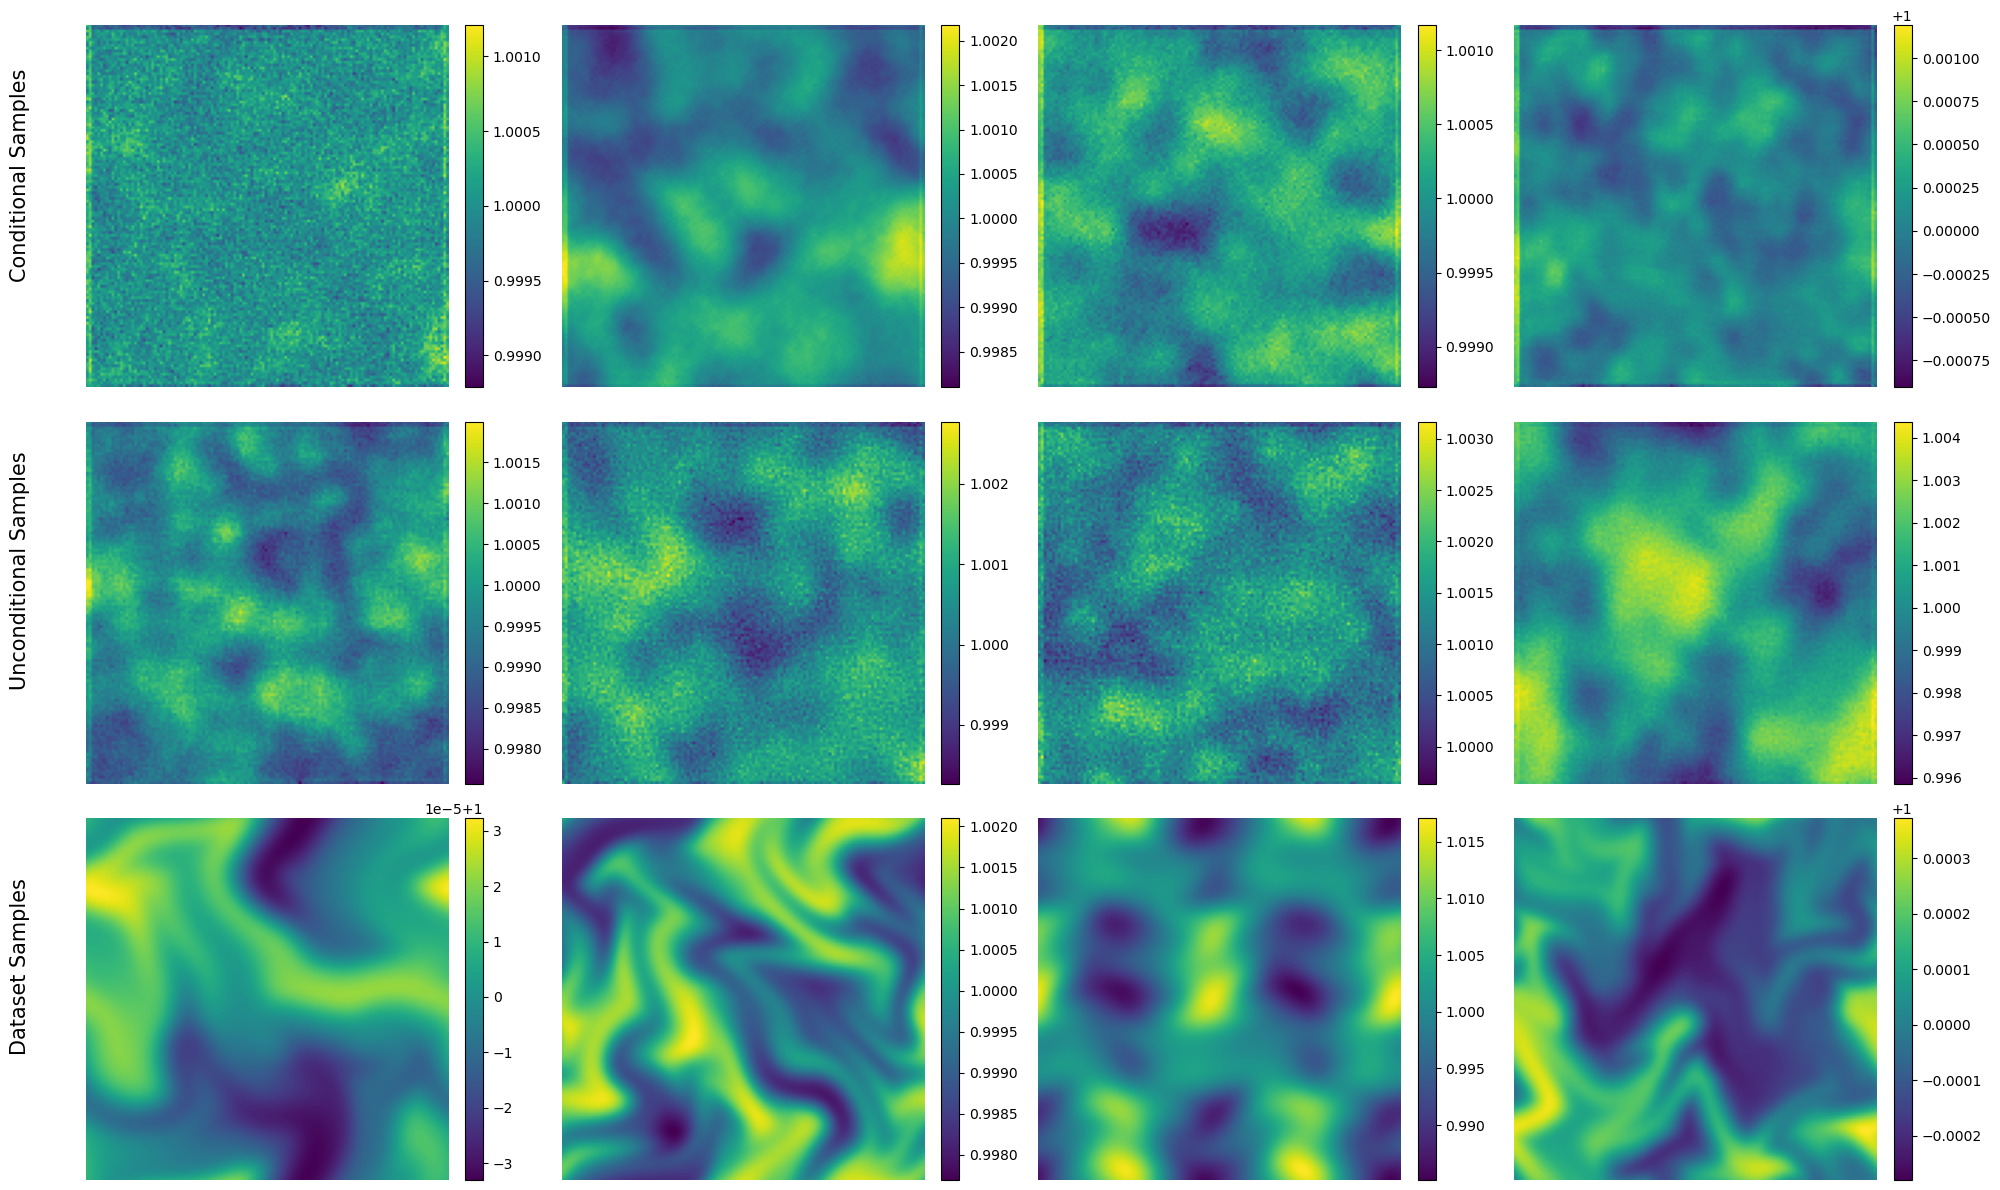

In [10]:
samples_conditional = sample_conditional[:4].detach().clone()
samples_unconditional = sample_unconditional[:4].detach().clone()
random_samples = [dataset[i] for i in torch.randint(len(dataset), (4,))]

fig, axs = plt.subplots(3, 4, figsize=(21, 12))  

for row, (samples, title) in enumerate([
    (samples_conditional, "Conditional Samples"),
    (samples_unconditional, "Unconditional Samples"),
    (random_samples, "Dataset Samples")
]):
    fig.text(0.05, 0.85 - row*0.33, title, rotation=90, verticalalignment='center', fontsize=15)
    
    for i, sample in enumerate(samples):
        if row < 2:  
            image_np = sample.detach().cpu().numpy().squeeze()
        else:  
            image = sample['input_fields'].squeeze(0).permute(2, 0, 1)[0, :, :].unsqueeze(0)
            image_np = image.detach().cpu().numpy().squeeze()
        
        im = axs[row, i].imshow(image_np, cmap='viridis')
        axs[row, i].set_axis_off()
        fig.colorbar(im, ax=axs[row, i], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.subplots_adjust(left=0.07, wspace=0.1)  
plt.show()

In [33]:
import torch
import torchvision.transforms as transforms
from torchmetrics.image.fid import FrechetInceptionDistance
from the_well.data import WellDataset
from torch.utils.data import DataLoader
dataset_test = WellDataset(
    well_base_path="./../the_well/datasets/",
    well_dataset_name="active_matter",
    well_split_name="test"
)


test_dataloader = DataLoader(dataset_test, batch_size=config.train_batch_size, shuffle=True)
avg_pool = torch.nn.AvgPool2d(kernel_size=2, stride=2)


conditional_samples = torch.load("temp/sample_conditional.pt")  
unconditional_samples = torch.load("temp/sample_unconditional.pt")

def get_real_samples(n_samples):
    samples = []
    while len(samples) < n_samples:
        real_batch = next(iter(test_dataloader))
        batch_samples = avg_pool(real_batch['input_fields'].squeeze(1).permute(0, 3, 1, 2)[:, 0, :, :].unsqueeze(1))
        samples.append(batch_samples)
    samples = torch.cat(samples, dim=0)
    return samples[:n_samples]  

real_samples = get_real_samples(len(dataset_test))


transform = transforms.Compose([
    transforms.Resize((299, 299)),                     
    transforms.Lambda(lambda x: x.repeat(3, 1, 1))     
])

def prepare_images(batch):
    processed = []
    for img in batch:
        img_resized = transforms.functional.resize(img, (299, 299))  
        img_rgb = img_resized.repeat(3, 1, 1)  
        processed.append(img_rgb)
    return torch.stack(processed)


real_prepared = prepare_images(real_samples)
cond_prepared = prepare_images(conditional_samples)
uncond_prepared = prepare_images(unconditional_samples)

fid = FrechetInceptionDistance(normalize=True)

fid.update(real_prepared, real=True)
fid.update(cond_prepared, real=False)
fid_conditional = fid.compute()
fid.reset()

fid.update(real_prepared, real=True)
fid.update(uncond_prepared, real=False)
fid_unconditional = fid.compute()

print("FID (Conditional):", fid_conditional.item())
print("FID (Unconditional):", fid_unconditional.item())


FID (Conditional): 109.9903335571289
FID (Unconditional): 101.28174591064453


In [34]:
import torch
import numpy as np
from skimage.metrics import structural_similarity as ssim

def compute_ssim(real, generated, return_best_matches=False):
    real_np = real.squeeze(1).cpu().numpy()
    generated_np = generated.squeeze(1).cpu().numpy()
    data_range = np.max(real_np) - np.min(real_np)

    best_ssim_values = []
    best_matches = []

    for g in generated_np:
        ssim_values = [ssim(r, g, data_range=data_range) for r in real_np]
        best_ssim = max(ssim_values)
        best_ssim_values.append(best_ssim)

        if return_best_matches:
            best_match_index = np.argmax(ssim_values)
            best_matches.append((g, real_np[best_match_index]))

    avg_ssim = sum(best_ssim_values) / len(best_ssim_values)

    if return_best_matches:
        return avg_ssim, best_matches
    else:
        return avg_ssim

ssim_conditional, ssim_best_matches_conditional = compute_ssim(real_samples, conditional_samples, return_best_matches=True)

ssim_unconditional, ssim_best_matches_unconditional = compute_ssim(real_samples, unconditional_samples, return_best_matches=True)

print("SSIM (Conditional):", ssim_conditional)
print("SSIM (Unconditional):", ssim_unconditional)



SSIM (Conditional): 0.9880644342913882
SSIM (Unconditional): 0.9810222317012576


C:\Users\simon\AppData\Local\Temp\ipykernel_2932\3198397192.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.01, 0, 0.99, 0.97])  # Adjust layout to accommodate suptitle and labels


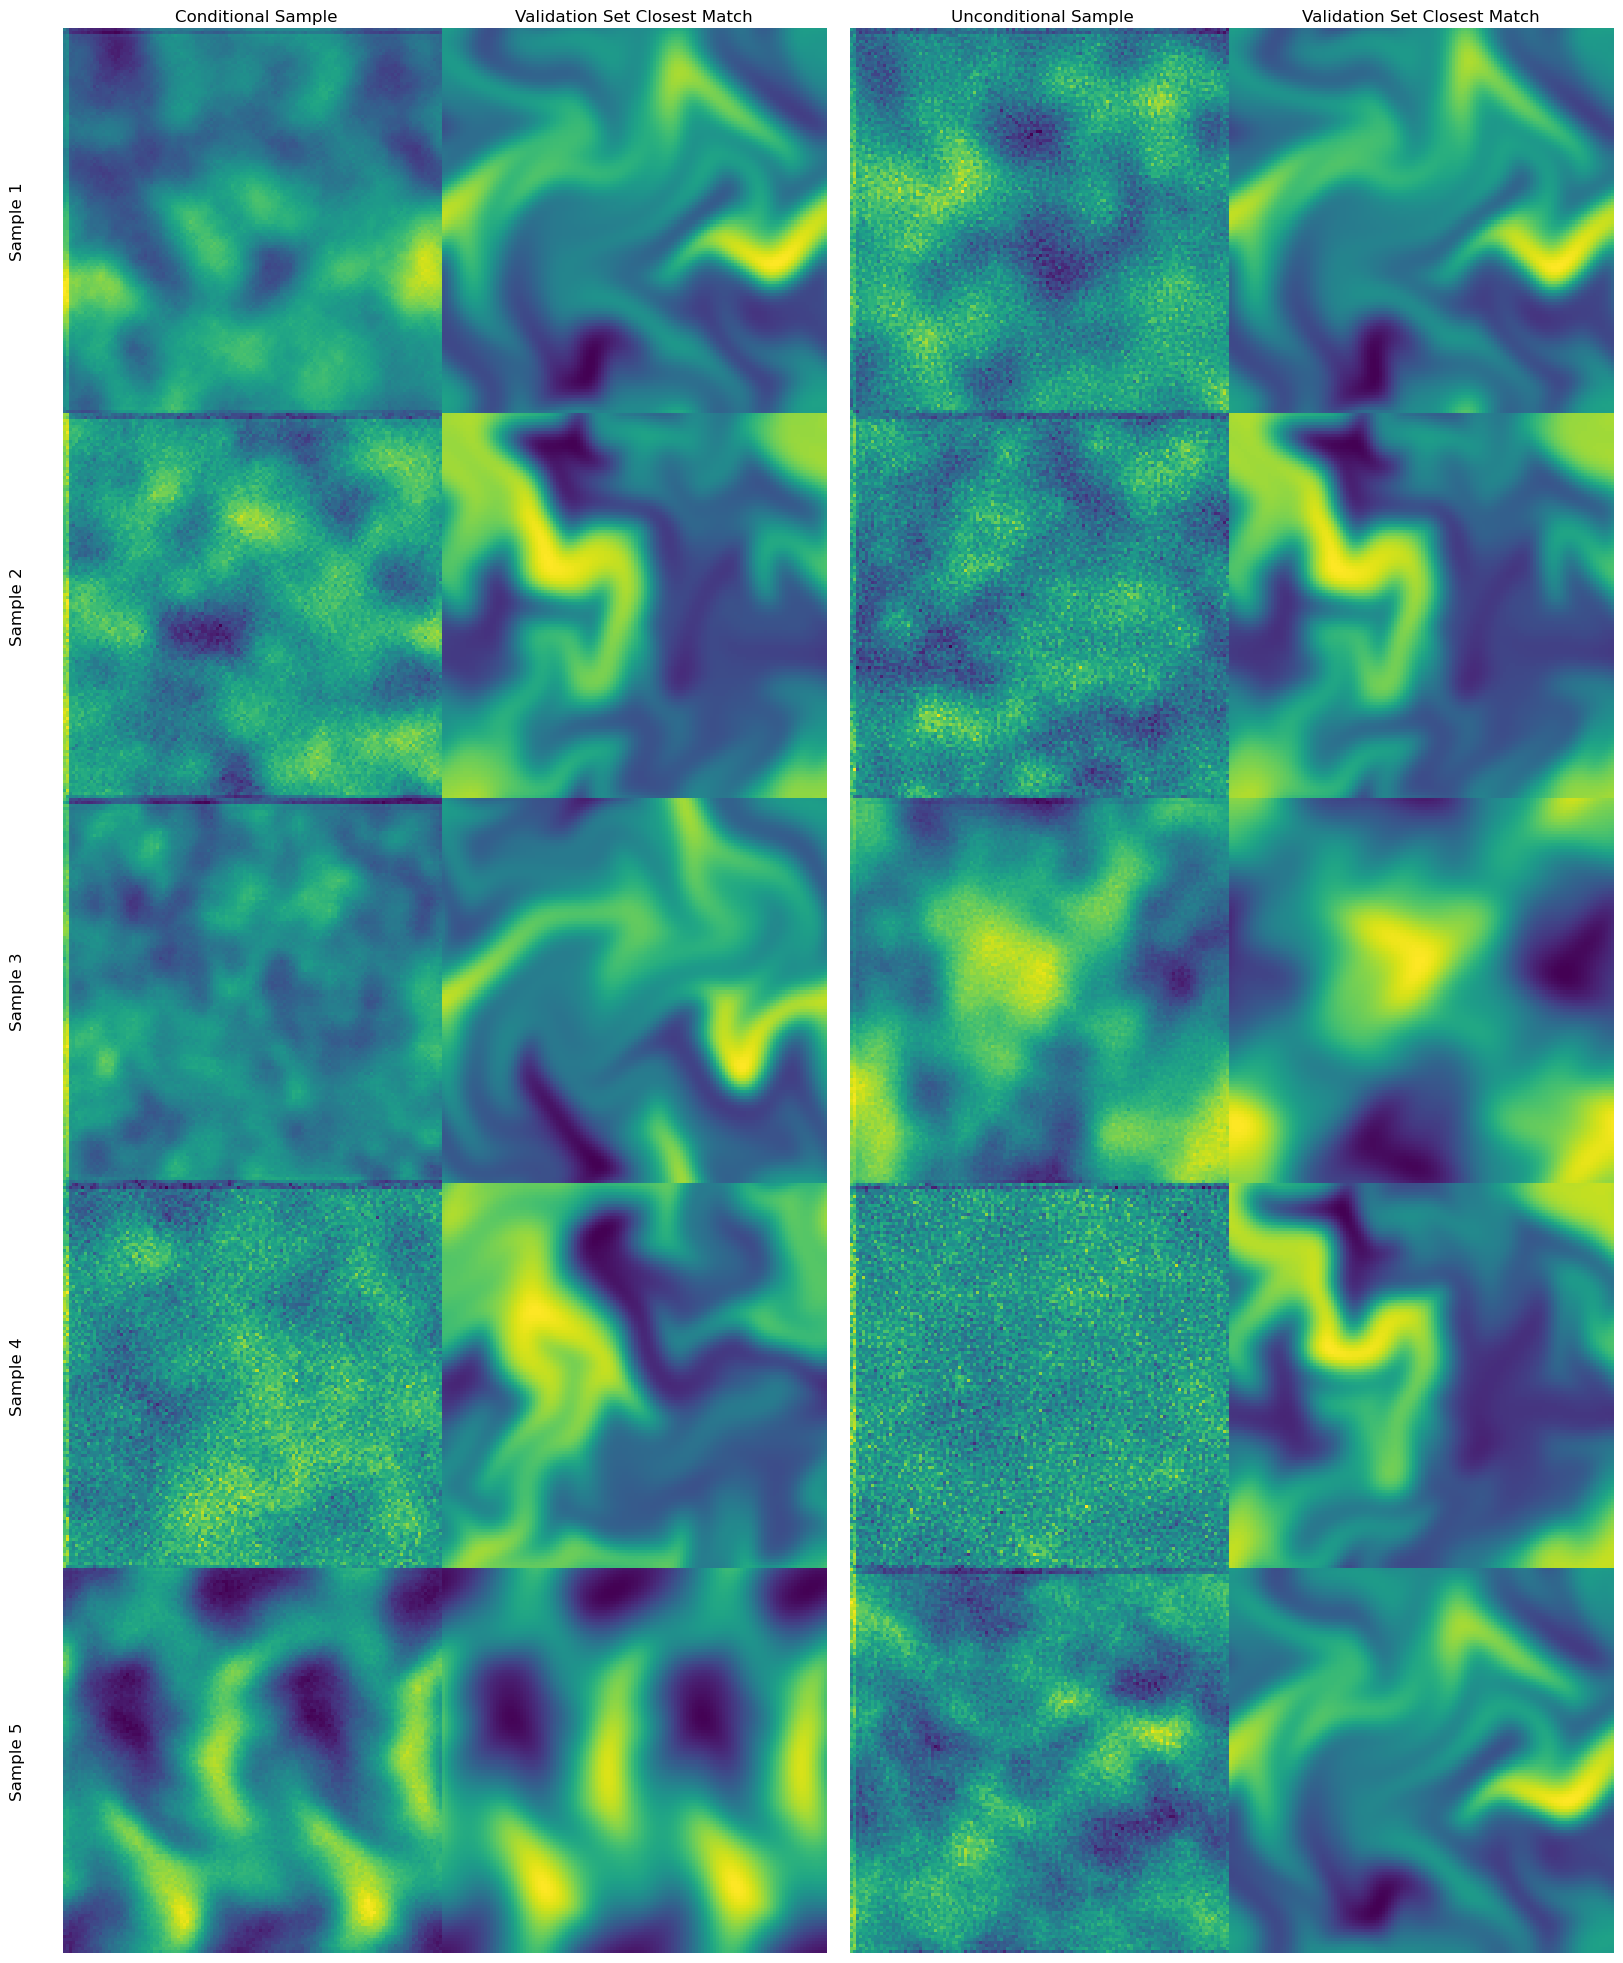

In [65]:
fig, axes = plt.subplots(5, 4, figsize=(20, 25), gridspec_kw={'wspace': 0.01, 'hspace': 0.00})
#fig.suptitle('Comparison of Conditional and Unconditional Samples', fontsize=18, y=0.98)

for i in range(5):
    for j in range(4):
        ax = axes[i, j]
        ax.set_axis_off()
        if j < 2:
            img = ssim_best_matches_conditional[i+1][j]
        else:
            img = ssim_best_matches_unconditional[i+1][j-2]
        ax.imshow(img)

col_labels = ['Conditional Sample', 'Validation Set Closest Match', 'Unconditional Sample', 'Validation Set Closest Match']
for ax, col in zip(axes[0], col_labels):
    ax.set_title(col, pad=5, fontsize=12)

for i, ax in enumerate(axes[:, 0]):
    ax.text(-0.1, 0.5, f'Sample {i+1}', rotation=90, ha='right', va='center', transform=ax.transAxes, fontsize=12)

for i in range(5):
    axes[i, 1].set_position([axes[i, 1].get_position().x0 - 0.005, 
                             axes[i, 1].get_position().y0,
                             axes[i, 1].get_position().width, 
                             axes[i, 1].get_position().height])
    axes[i, 2].set_position([axes[i, 2].get_position().x0 + 0.005, 
                             axes[i, 2].get_position().y0,
                             axes[i, 2].get_position().width, 
                             axes[i, 2].get_position().height])

plt.tight_layout(rect=[0.01, 0, 0.99, 0.97])  

plt.savefig('comparison_samples_ssim.png', dpi=300, bbox_inches='tight')
plt.show()

plt.close(fig)  


In [38]:
import torch
import numpy as np
from skimage.metrics import peak_signal_noise_ratio as psnr

def compute_psnr(real, generated, return_best_matches=False):
    real_np = real.squeeze(1).cpu().numpy()
    generated_np = generated.squeeze(1).cpu().numpy()
    
    data_range = np.max(real_np) - np.min(real_np)
    
    best_psnr_values = []
    best_matches = []
    
    for g in generated_np:
        psnr_values = [psnr(r, g, data_range=data_range) for r in real_np]
        best_psnr = max(psnr_values)
        best_psnr_values.append(best_psnr)
        
        if return_best_matches:
            best_match_index = np.argmax(psnr_values)
            best_matches.append((g, real_np[best_match_index]))
    
    avg_psnr = sum(best_psnr_values) / len(best_psnr_values)
    
    if return_best_matches:
        return avg_psnr, best_matches
    else:
        return avg_psnr

psnr_conditional, psnr_best_matches_conditional = compute_psnr(real_samples, conditional_samples, return_best_matches=True)

psnr_unconditional, psnr_best_matches_unconditional = compute_psnr(real_samples, unconditional_samples, return_best_matches=True)

print("PSNR (Conditional):", psnr_conditional)
print("PSNR (Unconditional):", psnr_unconditional)



PSNR (Conditional): 43.878017050049465
PSNR (Unconditional): 38.94438265281551


C:\Users\simon\AppData\Local\Temp\ipykernel_2932\3782124262.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.01, 0, 0.99, 0.97])  # Adjust layout to accommodate suptitle and labels


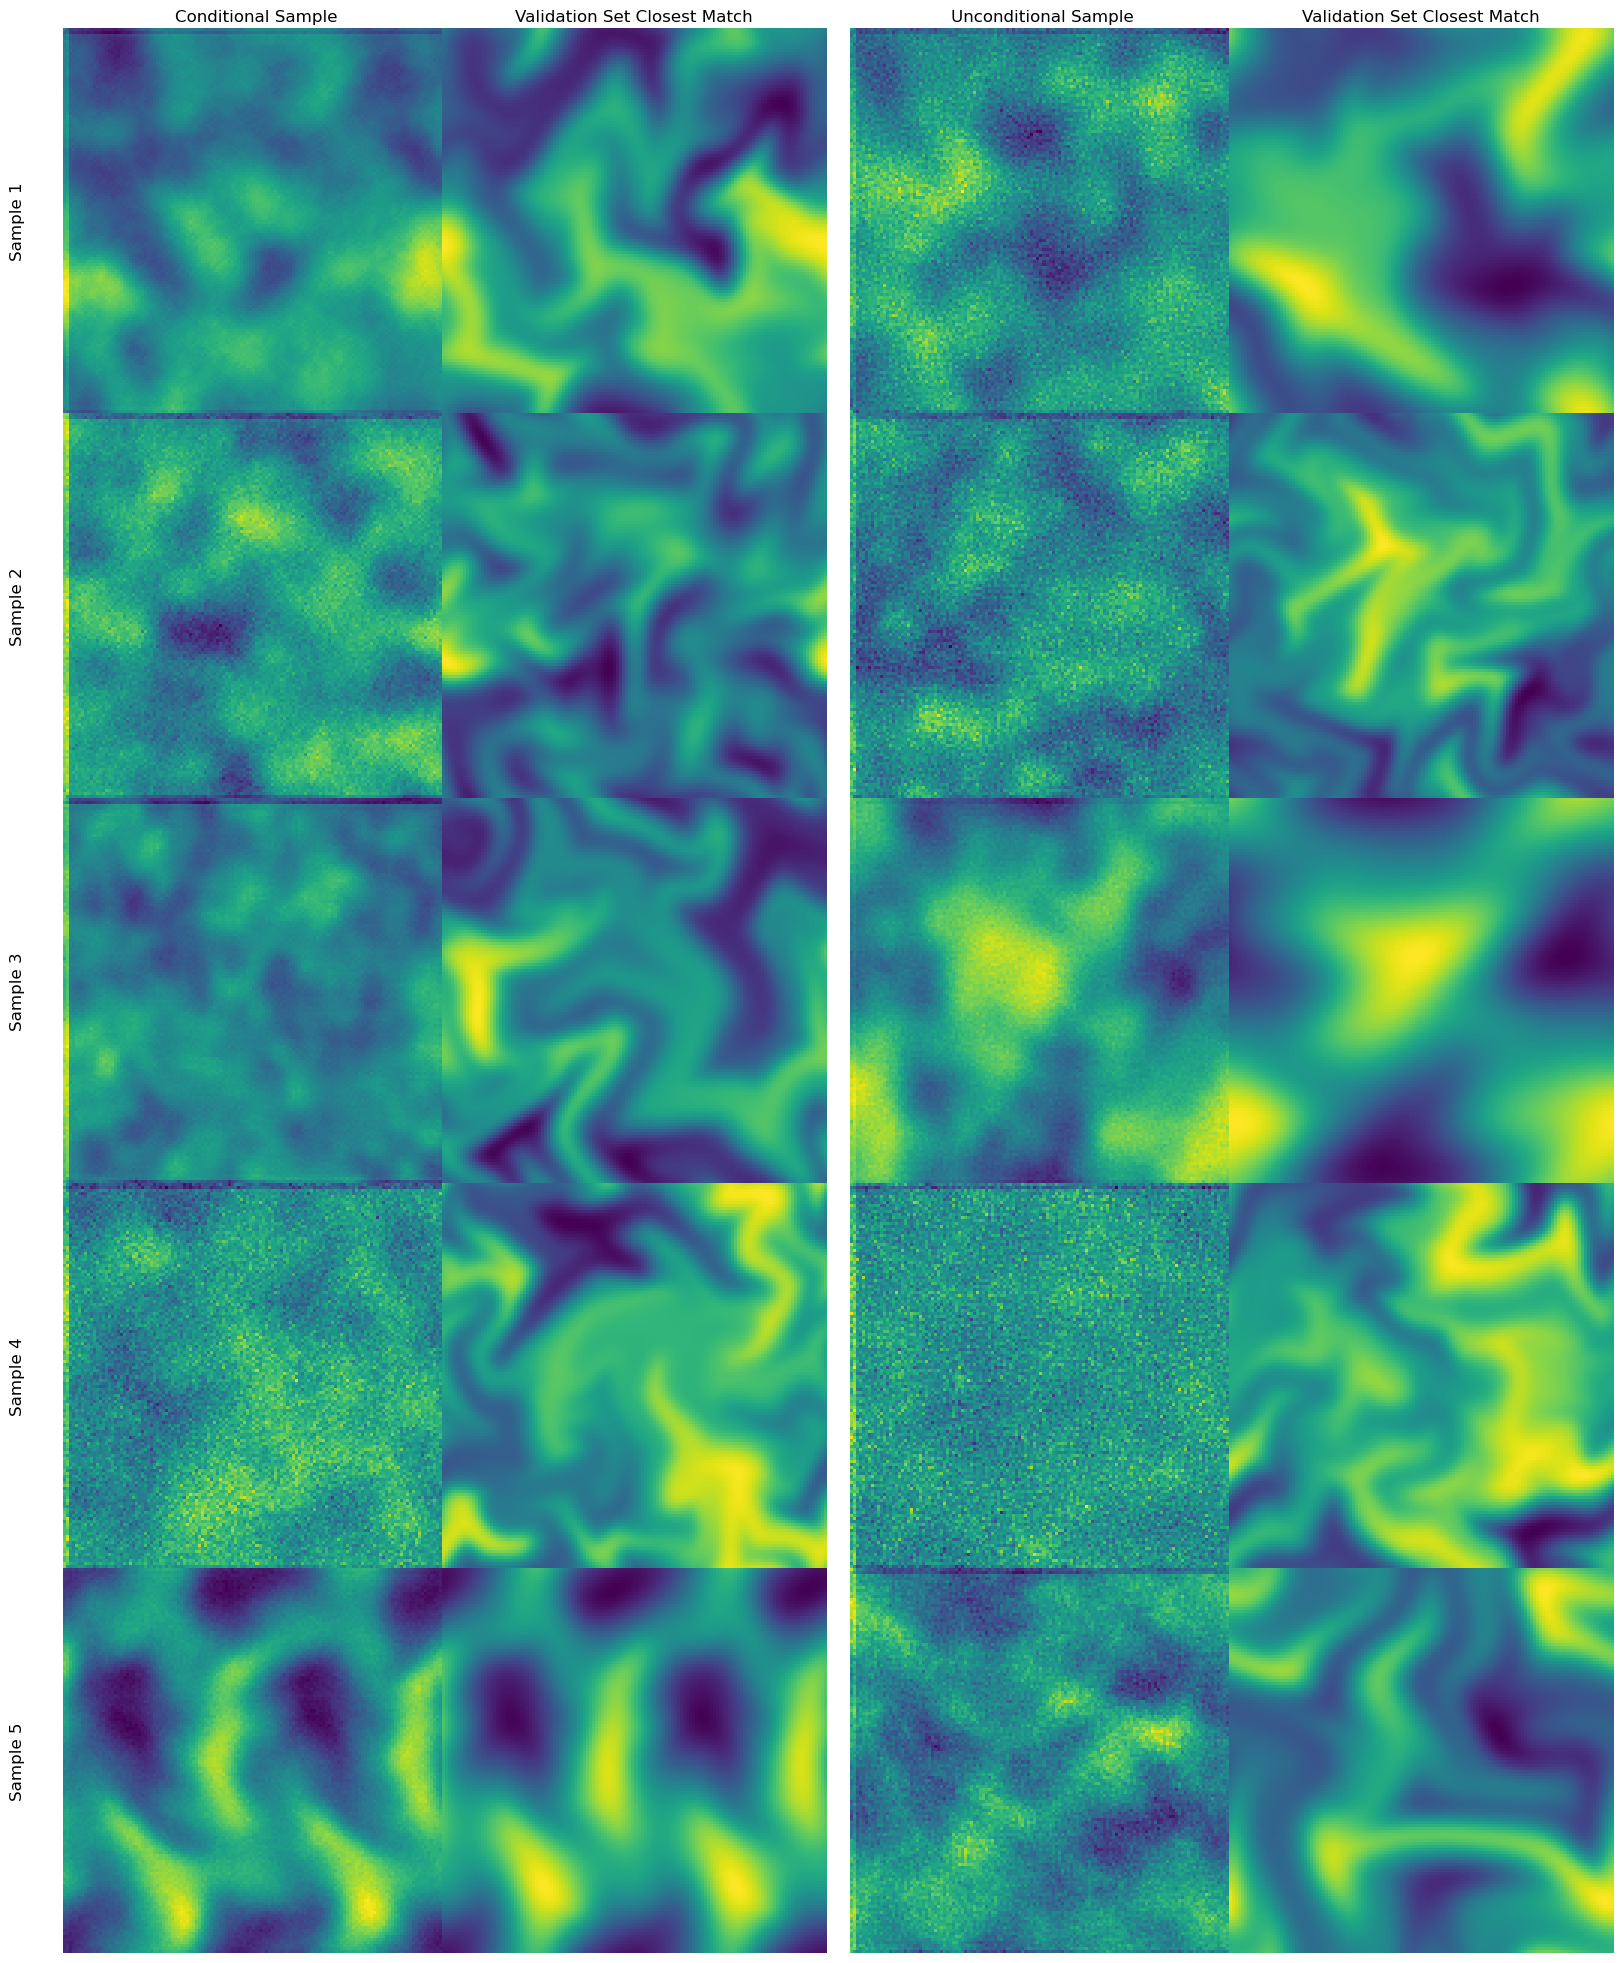

In [64]:
fig, axes = plt.subplots(5, 4, figsize=(20, 25), gridspec_kw={'wspace': 0.01, 'hspace': 0.00})
#fig.suptitle('Comparison of Conditional and Unconditional Samples', fontsize=18, y=0.98)

for i in range(5):
    for j in range(4):
        ax = axes[i, j]
        ax.set_axis_off()
        if j < 2:
            img = psnr_best_matches_conditional[i+1][j]
        else:
            img = psnr_best_matches_unconditional[i+1][j-2]
        ax.imshow(img)

col_labels = ['Conditional Sample', 'Validation Set Closest Match', 'Unconditional Sample', 'Validation Set Closest Match']
for ax, col in zip(axes[0], col_labels):
    ax.set_title(col, pad=5, fontsize=12)

for i, ax in enumerate(axes[:, 0]):
    ax.text(-0.1, 0.5, f'Sample {i+1}', rotation=90, ha='right', va='center', transform=ax.transAxes, fontsize=12)

for i in range(5):
    axes[i, 1].set_position([axes[i, 1].get_position().x0 - 0.005, 
                             axes[i, 1].get_position().y0,
                             axes[i, 1].get_position().width, 
                             axes[i, 1].get_position().height])
    axes[i, 2].set_position([axes[i, 2].get_position().x0 + 0.005, 
                             axes[i, 2].get_position().y0,
                             axes[i, 2].get_position().width, 
                             axes[i, 2].get_position().height])

plt.tight_layout(rect=[0.01, 0, 0.99, 0.97])  

plt.savefig('comparison_samples_psnr.png', dpi=300, bbox_inches='tight')

plt.show()

plt.close(fig)
